In [1]:
import os, time
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, classification_report

import torch
from torch import nn
from torch.optim import SGD, Adam
from torch.utils.data import DataLoader, RandomSampler
from torch.utils.data.dataset import Dataset
from torchvision.models import resnet
from torchvision import transforms, datasets, models
from torch.optim.lr_scheduler import ReduceLROnPlateau

__1. Generate a dataset of just three images, one for each class, and show your model correctly labels them. (display each image in your notebook, pass it to your model, and then print the prediction).__

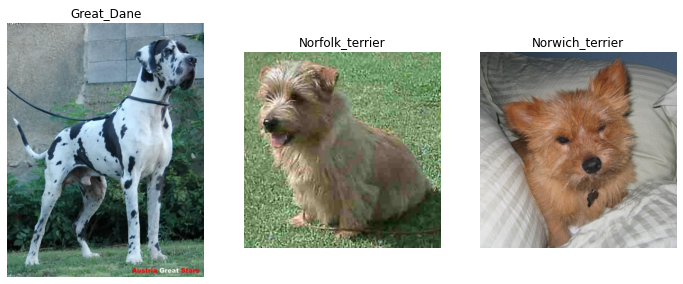

In [2]:
# Image data path for test

test_path = "D:\\MachineLearning\\dog_image\\test"

# Display each image
plt.figure(figsize=(12,12))
plt.subplot(1, 3, 1)
plt.title('Great_Dane')
plt.axis('off')
img = plt.imread("D:/MachineLearning/dog_image/test/Great_Dane/n02109047_26729.jpg")
plt.imshow(img)

plt.subplot(1, 3, 2)
plt.title('Norfolk_terrier')
plt.axis('off')
img = plt.imread("D:/MachineLearning/dog_image/test/Norfolk_terrier/n02094114_4611.jpg")
plt.imshow(img)

plt.subplot(1, 3, 3)
plt.title('Norwich_terrier')
plt.axis('off')
img = plt.imread("D:/MachineLearning/dog_image/test/Norwich_terrier/n02094258_3329.jpg")
plt.imshow(img)

In [3]:
# Load model trained from Project_2
ImgNet_model = torch.load('D:\\MachineLearning\\ImgModel.pth')

# test set transform rule
test_transform = transforms.Compose([
                                       transforms.Resize((224,224)),
                                       transforms.ToTensor(),
                                       transforms.Normalize(torch.Tensor([0.485, 0.456, 0.406]),
                                                            torch.Tensor([0.229, 0.224, 0.225]))])

# Pass imgae to the model
test_set = datasets.ImageFolder(root=test_path, transform = test_transform)
test_set_loader = DataLoader(test_set, batch_size=3, shuffle=False, pin_memory=True)

predictions = []
classifications = []

with torch.no_grad():
    ImgNet_model.eval()
    
    for i, batch in enumerate(test_set_loader):
        img, label = batch
        img, label = img.cuda(), label.cuda()
        output = ImgNet_model(img)
        output = output.detach().cpu().numpy()
        predictions.extend(np.argmax(output, 1))
        classifications.extend(label.cpu().numpy())

score = accuracy_score(predictions, classifications)
print('Accuracy on holdout dataset : {:.2%}'.format(score))

Accuracy on holdout dataset : 100.00%


As shown above, the predictions are all correct.

__2. Generate three datasets of your inputs, where each has only two of the classes. What do you predict the performance should be for three binary classifiers trained on these three datasets? Re-train your model on these three datasets, and discuss your results.__

I suppose that the datasets of Great_Dane vs Norfolk_terrier and Great_Dane vs Norwich_terrier would be have a better result when using the re-trained model (since more distinctive between these two breeds) comparing to the datasets of Norfolk_terrier and Norwich_terrier (which look almost the same).

In [6]:
# Using Project_2 code for creating model and test performance on holdout set

def new_model(path):
    # Image data path for train/validation/holdout

    train_path = path + "\\train"
    val_path = path + "\\validation"
    holdout_path = path + "\\holdout"

    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]

    # train transform rule

    train_transform = transforms.Compose([
                                         transforms.RandomRotation(degrees=45),
                                         transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
                                         transforms.Resize((224,224)),
                                         transforms.RandomHorizontalFlip(),
                                         transforms.ToTensor(),
                                         transforms.Normalize(torch.Tensor(mean),
                                                              torch.Tensor(std))])
    # validation transform rule

    val_transform = transforms.Compose([
                                        transforms.Resize((224,224)),
                                        transforms.ToTensor(),
                                        transforms.Normalize(torch.Tensor(mean),
                                                             torch.Tensor(std))])
    # holdout transform rule

    holdout_transform = transforms.Compose([
                                           transforms.Resize((224,224)),
                                           transforms.ToTensor(),
                                           transforms.Normalize(torch.Tensor(mean),
                                                                torch.Tensor(std))])

    # Apply transforms

    training_set = datasets.ImageFolder(root=train_path, transform=train_transform)
    validation_set = datasets.ImageFolder(root=val_path, transform=val_transform)
    test_set = datasets.ImageFolder(root=holdout_path, transform=holdout_transform)

    # Set up DataLoaders

    # since the validation and testing set images number is small, a batch_size of 20 is more reasonable (to have at least 2 to 3 batches).
    batch_size = 20

    training_set_loader = DataLoader(training_set, batch_size=batch_size, shuffle=True, pin_memory=True)
    validation_set_loader = DataLoader(validation_set, batch_size=batch_size, shuffle=True, pin_memory=True)
    test_set_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, pin_memory=True)

    # drop_last is set to default (False), which is because the data is so limited that we need them to be included.

    ImgNet_model = resnet.resnet152(pretrained=True)
    # Choosing ResNet152 as it has best accuracy among all ResNet versions (Top-1 error: 21.69, Top-5 error: 5.94)

    for name, module in ImgNet_model.named_children():
        if name in ['layer3','layer4','fc']:
            for param in module.parameters():
                param.requires_grad = True
        else:
            for param in module.parameters():
                param.requires_grad = False

    # original number of "fc" layer output features
    fc_fnum = ImgNet_model.fc.in_features

    # replace with sequential laters to predict 2 classes
    ImgNet_model.fc = nn.Sequential(nn.Linear(fc_fnum, 256),
                                     nn.ReLU(),
                                     nn.Dropout(),
                                     nn.Linear(256, 2))

    optimizer = Adam(ImgNet_model.parameters(), lr=0.0001)
    criterion = nn.CrossEntropyLoss()

    loaders = {'train': training_set_loader, 'val': validation_set_loader}

    # For train/validation loss record
    losses = {'train': [], 'val': []}
    accuracies = {'train': [], 'val': []}

    # Using GPU
    print(f'Using {torch.cuda.device_count()} GPUs')
    ImgNet_model.cuda()

    start = time.time()

    # set 10 epochs
    for epoch in range(10):
        for mode in ['train', 'val']:
            if mode == 'train':
                ImgNet_model.train()
            if mode == 'val':
                ImgNet_model.eval()

            # initialize loss, accuracy, number of data inputed
            epoch_loss = 0
            epoch_acc = 0
            samples = 0

            # training and validation
            # Using batch in dataloders
            for i, (inputs, targets) in enumerate(loaders[mode]):
                # Using CUDA 
                inputs = inputs.cuda()
                targets = targets.cuda()

                # initialize optimizer
                optimizer.zero_grad()
                # make predictions using current model
                output = ImgNet_model(inputs)
                # Call loss function
                loss = criterion(output, targets)

                # only update weights when training
                if mode == 'train':
                    # back propagation
                    loss.backward()
                    # Use optimizer to update weights/gradients
                    optimizer.step()

                # current model accuracy
                acc = accuracy_score(targets.data.cuda().cpu().numpy(), output.max(1)[1].cuda().cpu().numpy())

                # record training loss for each epoch
                epoch_loss += loss.data.item()*inputs.shape[0]
                # record training accuracy for each epoch
                epoch_acc += acc*inputs.shape[0]
                # current samples that been inputed
                samples += inputs.shape[0]

                # print every 5 iterations
                if i % 5 == 0:
                    print(f'[{mode}] Epoch {epoch+1}/{10} Iteration {i+1}/{len(loaders[mode])} Loss: {epoch_loss/samples:0.2f} Accuracy: {epoch_acc/samples:0.2f}')

            # After all batches finished

            epoch_loss /= samples
            epoch_acc /= samples

            # record loss
            losses[mode].append(epoch_loss)
            accuracies[mode].append(epoch_acc)

            # print train and validation loss, accuracy
            print(f'[{mode}] Epoch {epoch+1}/{10} Iteration {i+1}/{len(loaders[mode])} Loss: {epoch_loss:0.2f} Accuracy: {epoch_acc:0.2f}')

    print(f'Training time: {(time.time()-start)/60:0.2f} min.')
    
    # Result of the re-trained model 
    predictions = []
    classifications = []

    with torch.no_grad():
        ImgNet_model.eval()

        for i, batch in enumerate(test_set_loader):
            img, label = batch
            img, label = img.cuda(), label.cuda()
            output = ImgNet_model(img)
            output = output.detach().cpu().numpy()
            predictions.extend(np.argmax(output, 1))
            classifications.extend(label.cpu().numpy())

    score = accuracy_score(predictions, classifications)
    print('Accuracy on holdout dataset : {:.2%}'.format(score))

In [5]:
# Test1: Great_Dane vs Norfolk_terrier 
new_model("D:\\MachineLearning\\dog_img_bin")

Using 1 GPUs
[train] Epoch 1/10 Iteration 1/12 Loss: 0.67 Accuracy: 0.55
[train] Epoch 1/10 Iteration 6/12 Loss: 0.50 Accuracy: 0.84
[train] Epoch 1/10 Iteration 11/12 Loss: 0.35 Accuracy: 0.91
[train] Epoch 1/10 Iteration 12/12 Loss: 0.34 Accuracy: 0.92
[val] Epoch 1/10 Iteration 1/2 Loss: 0.00 Accuracy: 1.00
[val] Epoch 1/10 Iteration 2/2 Loss: 0.01 Accuracy: 1.00
[train] Epoch 2/10 Iteration 1/12 Loss: 0.04 Accuracy: 1.00
[train] Epoch 2/10 Iteration 6/12 Loss: 0.06 Accuracy: 0.98
[train] Epoch 2/10 Iteration 11/12 Loss: 0.05 Accuracy: 0.99
[train] Epoch 2/10 Iteration 12/12 Loss: 0.05 Accuracy: 0.99
[val] Epoch 2/10 Iteration 1/2 Loss: 0.00 Accuracy: 1.00
[val] Epoch 2/10 Iteration 2/2 Loss: 0.00 Accuracy: 1.00
[train] Epoch 3/10 Iteration 1/12 Loss: 0.01 Accuracy: 1.00
[train] Epoch 3/10 Iteration 6/12 Loss: 0.07 Accuracy: 0.98
[train] Epoch 3/10 Iteration 11/12 Loss: 0.04 Accuracy: 0.99
[train] Epoch 3/10 Iteration 12/12 Loss: 0.04 Accuracy: 0.99
[val] Epoch 3/10 Iteration 1/2 Lo

In [6]:
# Test2: Great_Dane vs Norwich_terrier
new_model("D:\\MachineLearning\\dog_img_bin")

Using 1 GPUs
[train] Epoch 1/10 Iteration 1/12 Loss: 0.75 Accuracy: 0.35
[train] Epoch 1/10 Iteration 6/12 Loss: 0.51 Accuracy: 0.78
[train] Epoch 1/10 Iteration 11/12 Loss: 0.36 Accuracy: 0.86
[train] Epoch 1/10 Iteration 12/12 Loss: 0.35 Accuracy: 0.87
[val] Epoch 1/10 Iteration 1/2 Loss: 0.01 Accuracy: 1.00
[val] Epoch 1/10 Iteration 2/2 Loss: 0.01 Accuracy: 1.00
[train] Epoch 2/10 Iteration 1/12 Loss: 0.09 Accuracy: 1.00
[train] Epoch 2/10 Iteration 6/12 Loss: 0.07 Accuracy: 0.98
[train] Epoch 2/10 Iteration 11/12 Loss: 0.07 Accuracy: 0.99
[train] Epoch 2/10 Iteration 12/12 Loss: 0.06 Accuracy: 0.99
[val] Epoch 2/10 Iteration 1/2 Loss: 0.00 Accuracy: 1.00
[val] Epoch 2/10 Iteration 2/2 Loss: 0.00 Accuracy: 1.00
[train] Epoch 3/10 Iteration 1/12 Loss: 0.05 Accuracy: 1.00
[train] Epoch 3/10 Iteration 6/12 Loss: 0.02 Accuracy: 1.00
[train] Epoch 3/10 Iteration 11/12 Loss: 0.03 Accuracy: 1.00
[train] Epoch 3/10 Iteration 12/12 Loss: 0.03 Accuracy: 1.00
[val] Epoch 3/10 Iteration 1/2 Lo

In [7]:
# Test3: Norwich_terrier vs Norwich_terrier
new_model("D:\\MachineLearning\\dog_img_bin")

Using 1 GPUs
[train] Epoch 1/10 Iteration 1/13 Loss: 0.70 Accuracy: 0.40
[train] Epoch 1/10 Iteration 6/13 Loss: 0.68 Accuracy: 0.58
[train] Epoch 1/10 Iteration 11/13 Loss: 0.63 Accuracy: 0.68
[train] Epoch 1/10 Iteration 13/13 Loss: 0.61 Accuracy: 0.70
[val] Epoch 1/10 Iteration 1/2 Loss: 0.32 Accuracy: 0.85
[val] Epoch 1/10 Iteration 2/2 Loss: 0.33 Accuracy: 0.82
[train] Epoch 2/10 Iteration 1/13 Loss: 0.38 Accuracy: 0.90
[train] Epoch 2/10 Iteration 6/13 Loss: 0.37 Accuracy: 0.89
[train] Epoch 2/10 Iteration 11/13 Loss: 0.34 Accuracy: 0.90
[train] Epoch 2/10 Iteration 13/13 Loss: 0.36 Accuracy: 0.88
[val] Epoch 2/10 Iteration 1/2 Loss: 0.21 Accuracy: 0.95
[val] Epoch 2/10 Iteration 2/2 Loss: 0.40 Accuracy: 0.85
[train] Epoch 3/10 Iteration 1/13 Loss: 0.10 Accuracy: 1.00
[train] Epoch 3/10 Iteration 6/13 Loss: 0.18 Accuracy: 0.94
[train] Epoch 3/10 Iteration 11/13 Loss: 0.21 Accuracy: 0.91
[train] Epoch 3/10 Iteration 13/13 Loss: 0.21 Accuracy: 0.92
[val] Epoch 3/10 Iteration 1/2 Lo

The model has great performance distinguishing Great_Dane vs Norfolk_terrier and Great_Dane vs Norwich_terrier (100% acc), but for Norwich_terrier vs Norwich_terrier, the model has trouble distinguish the breed (approx. 80% acc). This is exactly as expected, since it is less distinguishable between Norfolk_terrier and Norwich_terrier.

__3. Generate a dataset from your original dataset where 20% of the classes in one class are mis-labelled as the remaining two classes. How do you think your model performance will be impacted? Re-train your model on this test dataset, and discuss your results.__

I think the overall performance of the model will decrease, since the dataset itself has error in it.

In [4]:
# for training dataset for each breed (approx 100 images), 20% were changed to other breeds
# (i.e., 10 images for each breed of the other two breeds)
# validation and holdout set remain correct

# model performance


# Image data path for train/validation/holdout

train_path = "D:\\MachineLearning\\dog_img_mis\\train"
val_path = "D:\\MachineLearning\\dog_img_mis\\validation"
holdout_path = "D:\\MachineLearning\\dog_img_mis\\holdout"

mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

# train transform rule

train_transform = transforms.Compose([
                                     transforms.RandomRotation(degrees=45),
                                     transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
                                     transforms.Resize((224,224)),
                                     transforms.RandomHorizontalFlip(),
                                     transforms.ToTensor(),
                                     transforms.Normalize(torch.Tensor(mean),
                                                          torch.Tensor(std))])
# validation transform rule

val_transform = transforms.Compose([
                                    transforms.Resize((224,224)),
                                    transforms.ToTensor(),
                                    transforms.Normalize(torch.Tensor(mean),
                                                         torch.Tensor(std))])
# holdout transform rule

holdout_transform = transforms.Compose([
                                       transforms.Resize((224,224)),
                                       transforms.ToTensor(),
                                       transforms.Normalize(torch.Tensor(mean),
                                                            torch.Tensor(std))])

# Apply transforms

training_set = datasets.ImageFolder(root=train_path, transform=train_transform)
validation_set = datasets.ImageFolder(root=val_path, transform=val_transform)
test_set = datasets.ImageFolder(root=holdout_path, transform=holdout_transform)

# Set up DataLoaders

# since the validation and testing set images number is small, a batch_size of 20 is more reasonable (to have at least 2 to 3 batches).
batch_size = 20

training_set_loader = DataLoader(training_set, batch_size=batch_size, shuffle=True)
validation_set_loader = DataLoader(validation_set, batch_size=batch_size, shuffle=True)
test_set_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

# drop_last is set to default (False), which is because the data is so limited that we need them to be included.

ImgNet_model = resnet.resnet152(pretrained=True)
# Choosing ResNet152 as it has best accuracy among all ResNet versions (Top-1 error: 21.69, Top-5 error: 5.94)

for name, module in ImgNet_model.named_children():
    if name in ['layer3','layer4','fc']:
        for param in module.parameters():
            param.requires_grad = True
    else:
        for param in module.parameters():
            param.requires_grad = False

# original number of "fc" layer output features
fc_fnum = ImgNet_model.fc.in_features

# replace with sequential laters to predict 3 classes
ImgNet_model.fc = nn.Sequential(nn.Linear(fc_fnum, 256),
                                 nn.ReLU(),
                                 nn.Dropout(),
                                 nn.Linear(256, 3))

optimizer = Adam(ImgNet_model.parameters(), lr=0.0001)
criterion = nn.CrossEntropyLoss()

loaders = {'train': training_set_loader, 'val': validation_set_loader}

# For train/validation loss record
losses = {'train': [], 'val': []}
accuracies = {'train': [], 'val': []}

# Using GPU
print(f'Using {torch.cuda.device_count()} GPUs')
ImgNet_model.cuda()

start = time.time()

# set 10 epochs
for epoch in range(10):
    for mode in ['train', 'val']:
        if mode == 'train':
            ImgNet_model.train()
        if mode == 'val':
            ImgNet_model.eval()

        # initialize loss, accuracy, number of data inputed
        epoch_loss = 0
        epoch_acc = 0
        samples = 0

        # training and validation
        # Using batch in dataloders
        for i, (inputs, targets) in enumerate(loaders[mode]):
            # Using CUDA 
            inputs = inputs.cuda()
            targets = targets.cuda()

            # initialize optimizer
            optimizer.zero_grad()
            # make predictions using current model
            output = ImgNet_model(inputs)
            # Call loss function
            loss = criterion(output, targets)

            # only update weights when training
            if mode == 'train':
                # back propagation
                loss.backward()
                # Use optimizer to update weights/gradients
                optimizer.step()

            # current model accuracy
            acc = accuracy_score(targets.data.cuda().cpu().numpy(), output.max(1)[1].cuda().cpu().numpy())

            # record training loss for each epoch
            epoch_loss += loss.data.item()*inputs.shape[0]
            # record training accuracy for each epoch
            epoch_acc += acc*inputs.shape[0]
            # current samples that been inputed
            samples += inputs.shape[0]

            # print every 5 iterations
            if i % 5 == 0:
                print(f'[{mode}] Epoch {epoch+1}/{10} Iteration {i+1}/{len(loaders[mode])} Loss: {epoch_loss/samples:0.2f} Accuracy: {epoch_acc/samples:0.2f}')

        # After all batches finished

        epoch_loss /= samples
        epoch_acc /= samples

        # record loss
        losses[mode].append(epoch_loss)
        accuracies[mode].append(epoch_acc)

        # print train and validation loss, accuracy
        print(f'[{mode}] Epoch {epoch+1}/{10} Iteration {i+1}/{len(loaders[mode])} Loss: {epoch_loss:0.2f} Accuracy: {epoch_acc:0.2f}')

print(f'Training time: {(time.time()-start)/60:0.2f} min.')

# Result of the re-trained model 
predictions = []
classifications = []

with torch.no_grad():
    ImgNet_model.eval()

    for i, batch in enumerate(test_set_loader):
        img, label = batch
        img, label = img.cuda(), label.cuda()
        output = ImgNet_model(img)
        output = output.detach().cpu().numpy()
        predictions.extend(np.argmax(output, 1))
        classifications.extend(label.cpu().numpy())

score = accuracy_score(predictions, classifications)
print('Accuracy on holdout dataset : {:.2%}'.format(score))

Using 1 GPUs
[train] Epoch 1/10 Iteration 1/18 Loss: 1.08 Accuracy: 0.35
[train] Epoch 1/10 Iteration 6/18 Loss: 1.04 Accuracy: 0.48
[train] Epoch 1/10 Iteration 11/18 Loss: 0.96 Accuracy: 0.54
[train] Epoch 1/10 Iteration 16/18 Loss: 0.93 Accuracy: 0.57
[train] Epoch 1/10 Iteration 18/18 Loss: 0.95 Accuracy: 0.55
[val] Epoch 1/10 Iteration 1/3 Loss: 0.57 Accuracy: 0.65
[val] Epoch 1/10 Iteration 3/3 Loss: 0.45 Accuracy: 0.78
[train] Epoch 2/10 Iteration 1/18 Loss: 0.62 Accuracy: 0.85
[train] Epoch 2/10 Iteration 6/18 Loss: 0.65 Accuracy: 0.75
[train] Epoch 2/10 Iteration 11/18 Loss: 0.67 Accuracy: 0.74
[train] Epoch 2/10 Iteration 16/18 Loss: 0.66 Accuracy: 0.73
[train] Epoch 2/10 Iteration 18/18 Loss: 0.66 Accuracy: 0.73
[val] Epoch 2/10 Iteration 1/3 Loss: 0.27 Accuracy: 1.00
[val] Epoch 2/10 Iteration 3/3 Loss: 0.34 Accuracy: 0.94
[train] Epoch 3/10 Iteration 1/18 Loss: 0.40 Accuracy: 0.95
[train] Epoch 3/10 Iteration 6/18 Loss: 0.53 Accuracy: 0.84
[train] Epoch 3/10 Iteration 11/1

As shown above, the result performance greatly reduced due to the error in the dataset.

__4. Take a look at each of the images in all classes individually. What aspects of the image (such as backgrounds) might be influencing the decision-making of the model, besides the dogs themselves?__

1. the background of the images (e.g. color)
2. The proportion of dogs in the picture
3. Some of the images have people in it
4. The exposure of the images (e.g. too dark/too bright)
5. The angle of the dog in the images

__5. Calculate the "average image" across all pixels of each of your classes in your training dataset. Are your results consistent with the previous item?__

In [24]:
import os, numpy, PIL
from PIL import Image, ImageStat
import glob

def average_image(path, name):
    breed = []
    
    for filename in glob.glob(path + '*.jpg'):
        im=Image.open(filename)
        stat = ImageStat.Stat(im)
        breed.append(stat.mean)
    
    print(f'{name}: {breed[:10]}')
    
    R, G, B = 0, 0, 0
    for stat in breed:
        R += stat[0]
        G += stat[1]
        B += stat[2]
    
    print(f'{name} average image: {R/len(Great_Dane):0.3f} , {G/len(Great_Dane):0.3f} , {B/len(Great_Dane):0.3f}')

average_image('D:/MachineLearning/dog_image/train/Great_Dane/', 'Great_Dane')
average_image('D:/MachineLearning/dog_image/train/Norfolk_terrier/', 'Norfolk_terrier')
average_image('D:/MachineLearning/dog_image/train/Norwich_terrier/', 'Norwich_terrier')

Great_Dane: [[85.786435, 74.9383, 70.45449], [62.66549340369393, 52.04951451187335, 28.47934036939314], [116.64232533333333, 82.277376, 51.671328], [139.1808684110732, 129.90244280116295, 120.45602957906712], [56.577753753753754, 45.54080480480481, 30.63082882882883], [117.54073482428115, 121.57157827476038, 130.3974504792332], [140.0837125748503, 117.59377844311378, 99.88866467065868], [115.84564210526315, 117.47610526315789, 108.84416842105263], [100.856176, 113.946584, 106.597592], [104.75963363363364, 109.98724324324324, 83.62911711711712]]
Great_Dane average image: 115.921 , 113.708 , 100.051
Norfolk_terrier: [[132.08835, 99.322375, 71.016925], [168.35583652618135, 134.75471264367815, 100.81532567049808], [116.82032432432432, 100.12472072072072, 80.95488888888889], [94.10380266666667, 134.956416, 81.81893866666667], [114.65060266666667, 127.472032, 97.44947733333333], [118.14700266666667, 107.175376, 103.29115733333333], [163.3211195652174, 156.38259239130434, 144.86572826086956],

The above result shows the average R,G,B for each image of the first 10 images in each class, as it shows, the result is non-consistent with other images in the same class. So there is a lot of noise.

__6. Is the data biased in any way that could impact your results? Why or why not?__

Yes, for example, the Norfolk_terrier and Norwich_terrier seems including dogs from a large variaty of age, whereas Great_Dane are mostly adult. Another bias could be due to the size of the dog, as Great_Dane is larger than the other two breeds, the background of the images could have more details (more different RGB pixels) than the other two breeds. These bias would mislead the model to learn false patterns.

__7. If you noted some potential biases in the modeling/dataset above, discuss how you could help mitigate these biases (you don't need to implement, just discuss). If you didn't note any biases in this dataset, discuss what biases there could have been, and how the dataset designers might have helped mitigate them.__

I would implement image segmentation to drop out the background, and also adjust the exposure of the image to further reduce the impact of bias on the model learning.

__Re-train model, but this time don't use a pre-trained version__

In [26]:
# Image data path for train/validation/holdout

train_path = "D:\\MachineLearning\\dog_image\\train"
val_path = "D:\\MachineLearning\\dog_image\\validation"
holdout_path = "D:\\MachineLearning\\dog_image\\holdout"

mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

# train transform rule

train_transform = transforms.Compose([
                                     transforms.RandomRotation(degrees=45),
                                     transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
                                     transforms.Resize((224,224)),
                                     transforms.RandomHorizontalFlip(),
                                     transforms.ToTensor(),
                                     transforms.Normalize(torch.Tensor(mean),
                                                          torch.Tensor(std))])
# validation transform rule

val_transform = transforms.Compose([
                                    transforms.Resize((224,224)),
                                    transforms.ToTensor(),
                                    transforms.Normalize(torch.Tensor(mean),
                                                         torch.Tensor(std))])
# holdout transform rule

holdout_transform = transforms.Compose([
                                       transforms.Resize((224,224)),
                                       transforms.ToTensor(),
                                       transforms.Normalize(torch.Tensor(mean),
                                                            torch.Tensor(std))])

# Apply transforms

training_set = datasets.ImageFolder(root=train_path, transform=train_transform)
validation_set = datasets.ImageFolder(root=val_path, transform=val_transform)
test_set = datasets.ImageFolder(root=holdout_path, transform=holdout_transform)

# Set up DataLoaders

# since the validation and testing set images number is small, a batch_size of 20 is more reasonable (to have at least 2 to 3 batches).
batch_size = 20

training_set_loader = DataLoader(training_set, batch_size=batch_size, shuffle=True, pin_memory=True)
validation_set_loader = DataLoader(validation_set, batch_size=batch_size, shuffle=True, pin_memory=True)
test_set_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, pin_memory=True)

# drop_last is set to default (False), which is because the data is so limited that we need them to be included.

ImgNet_model = resnet.resnet152(pretrained=False)
# Choosing ResNet152 as it has best accuracy among all ResNet versions (Top-1 error: 21.69, Top-5 error: 5.94)

for name, module in ImgNet_model.named_children():
    for param in module.parameters():
        print(name + ' is unfrozen')
        param.requires_grad = True

# original number of "fc" layer output features
fc_fnum = ImgNet_model.fc.in_features

# replace with sequential laters to predict 3 classes
ImgNet_model.fc = nn.Sequential(nn.Linear(fc_fnum, 256),
                                 nn.ReLU(),
                                 nn.Dropout(),
                                 nn.Linear(256, 3))

optimizer = Adam(ImgNet_model.parameters(), lr=0.0001)
criterion = nn.CrossEntropyLoss()

loaders = {'train': training_set_loader, 'val': validation_set_loader}

# For train/validation loss record
losses = {'train': [], 'val': []}
accuracies = {'train': [], 'val': []}

# Using GPU
print(f'Using {torch.cuda.device_count()} GPUs')
ImgNet_model.cuda()

start = time.time()

# set 50 epochs
for epoch in range(50):
    for mode in ['train', 'val']:
        if mode == 'train':
            ImgNet_model.train()
        if mode == 'val':
            ImgNet_model.eval()

        # initialize loss, accuracy, number of data inputed
        epoch_loss = 0
        epoch_acc = 0
        samples = 0

        # training and validation
        # Using batch in dataloders
        for i, (inputs, targets) in enumerate(loaders[mode]):
            # Using CUDA 
            inputs = inputs.cuda()
            targets = targets.cuda()

            # initialize optimizer
            optimizer.zero_grad()
            # make predictions using current model
            output = ImgNet_model(inputs)
            # Call loss function
            loss = criterion(output, targets)

            # only update weights when training
            if mode == 'train':
                # back propagation
                loss.backward()
                # Use optimizer to update weights/gradients
                optimizer.step()

            # current model accuracy
            acc = accuracy_score(targets.data.cuda().cpu().numpy(), output.max(1)[1].cuda().cpu().numpy())

            # record training loss for each epoch
            epoch_loss += loss.data.item()*inputs.shape[0]
            # record training accuracy for each epoch
            epoch_acc += acc*inputs.shape[0]
            # current samples that been inputed
            samples += inputs.shape[0]

            # print every 5 iterations
            if i % 5 == 0:
                print(f'[{mode}] Epoch {epoch+1}/{10} Iteration {i+1}/{len(loaders[mode])} Loss: {epoch_loss/samples:0.2f} Accuracy: {epoch_acc/samples:0.2f}')

        # After all batches finished

        epoch_loss /= samples
        epoch_acc /= samples

        # record loss
        losses[mode].append(epoch_loss)
        accuracies[mode].append(epoch_acc)

        # print train and validation loss, accuracy
        print(f'[{mode}] Epoch {epoch+1}/{10} Iteration {i+1}/{len(loaders[mode])} Loss: {epoch_loss:0.2f} Accuracy: {epoch_acc:0.2f}')

print(f'Training time: {(time.time()-start)/60:0.2f} min.')

# Result of the re-trained model 
predictions = []
classifications = []

with torch.no_grad():
    ImgNet_model.eval()

    for i, batch in enumerate(test_set_loader):
        img, label = batch
        img, label = img.cuda(), label.cuda()
        output = ImgNet_model(img)
        output = output.detach().cpu().numpy()
        predictions.extend(np.argmax(output, 1))
        classifications.extend(label.cpu().numpy())

score = accuracy_score(predictions, classifications)
print('Accuracy on holdout dataset : {:.2%}'.format(score))

conv1 is unfrozen
bn1 is unfrozen
bn1 is unfrozen
layer1 is unfrozen
layer1 is unfrozen
layer1 is unfrozen
layer1 is unfrozen
layer1 is unfrozen
layer1 is unfrozen
layer1 is unfrozen
layer1 is unfrozen
layer1 is unfrozen
layer1 is unfrozen
layer1 is unfrozen
layer1 is unfrozen
layer1 is unfrozen
layer1 is unfrozen
layer1 is unfrozen
layer1 is unfrozen
layer1 is unfrozen
layer1 is unfrozen
layer1 is unfrozen
layer1 is unfrozen
layer1 is unfrozen
layer1 is unfrozen
layer1 is unfrozen
layer1 is unfrozen
layer1 is unfrozen
layer1 is unfrozen
layer1 is unfrozen
layer1 is unfrozen
layer1 is unfrozen
layer1 is unfrozen
layer2 is unfrozen
layer2 is unfrozen
layer2 is unfrozen
layer2 is unfrozen
layer2 is unfrozen
layer2 is unfrozen
layer2 is unfrozen
layer2 is unfrozen
layer2 is unfrozen
layer2 is unfrozen
layer2 is unfrozen
layer2 is unfrozen
layer2 is unfrozen
layer2 is unfrozen
layer2 is unfrozen
layer2 is unfrozen
layer2 is unfrozen
layer2 is unfrozen
layer2 is unfrozen
layer2 is unfrozen


[train] Epoch 1/10 Iteration 1/18 Loss: 1.04 Accuracy: 0.65
[train] Epoch 1/10 Iteration 6/18 Loss: 1.18 Accuracy: 0.38
[train] Epoch 1/10 Iteration 11/18 Loss: 1.21 Accuracy: 0.36
[train] Epoch 1/10 Iteration 16/18 Loss: 1.23 Accuracy: 0.36
[train] Epoch 1/10 Iteration 18/18 Loss: 1.22 Accuracy: 0.36
[val] Epoch 1/10 Iteration 1/3 Loss: 1.14 Accuracy: 0.40
[val] Epoch 1/10 Iteration 3/3 Loss: 1.14 Accuracy: 0.33
[train] Epoch 2/10 Iteration 1/18 Loss: 1.17 Accuracy: 0.25
[train] Epoch 2/10 Iteration 6/18 Loss: 1.17 Accuracy: 0.30
[train] Epoch 2/10 Iteration 11/18 Loss: 1.16 Accuracy: 0.31
[train] Epoch 2/10 Iteration 16/18 Loss: 1.16 Accuracy: 0.34
[train] Epoch 2/10 Iteration 18/18 Loss: 1.16 Accuracy: 0.34
[val] Epoch 2/10 Iteration 1/3 Loss: 1.16 Accuracy: 0.35
[val] Epoch 2/10 Iteration 3/3 Loss: 1.15 Accuracy: 0.35
[train] Epoch 3/10 Iteration 1/18 Loss: 1.07 Accuracy: 0.50
[train] Epoch 3/10 Iteration 6/18 Loss: 1.18 Accuracy: 0.30
[train] Epoch 3/10 Iteration 11/18 Loss: 1.14 

[train] Epoch 20/10 Iteration 18/18 Loss: 1.03 Accuracy: 0.45
[val] Epoch 20/10 Iteration 1/3 Loss: 1.02 Accuracy: 0.55
[val] Epoch 20/10 Iteration 3/3 Loss: 1.04 Accuracy: 0.59
[train] Epoch 21/10 Iteration 1/18 Loss: 0.99 Accuracy: 0.45
[train] Epoch 21/10 Iteration 6/18 Loss: 0.99 Accuracy: 0.50
[train] Epoch 21/10 Iteration 11/18 Loss: 0.98 Accuracy: 0.51
[train] Epoch 21/10 Iteration 16/18 Loss: 0.99 Accuracy: 0.50
[train] Epoch 21/10 Iteration 18/18 Loss: 1.00 Accuracy: 0.49
[val] Epoch 21/10 Iteration 1/3 Loss: 0.98 Accuracy: 0.65
[val] Epoch 21/10 Iteration 3/3 Loss: 1.04 Accuracy: 0.53
[train] Epoch 22/10 Iteration 1/18 Loss: 1.02 Accuracy: 0.40
[train] Epoch 22/10 Iteration 6/18 Loss: 1.03 Accuracy: 0.35
[train] Epoch 22/10 Iteration 11/18 Loss: 1.03 Accuracy: 0.40
[train] Epoch 22/10 Iteration 16/18 Loss: 1.02 Accuracy: 0.41
[train] Epoch 22/10 Iteration 18/18 Loss: 1.02 Accuracy: 0.42
[val] Epoch 22/10 Iteration 1/3 Loss: 0.98 Accuracy: 0.50
[val] Epoch 22/10 Iteration 3/3 

[train] Epoch 40/10 Iteration 1/18 Loss: 1.05 Accuracy: 0.40
[train] Epoch 40/10 Iteration 6/18 Loss: 1.01 Accuracy: 0.43
[train] Epoch 40/10 Iteration 11/18 Loss: 1.00 Accuracy: 0.47
[train] Epoch 40/10 Iteration 16/18 Loss: 0.99 Accuracy: 0.46
[train] Epoch 40/10 Iteration 18/18 Loss: 0.99 Accuracy: 0.47
[val] Epoch 40/10 Iteration 1/3 Loss: 0.94 Accuracy: 0.60
[val] Epoch 40/10 Iteration 3/3 Loss: 0.93 Accuracy: 0.57
[train] Epoch 41/10 Iteration 1/18 Loss: 0.95 Accuracy: 0.40
[train] Epoch 41/10 Iteration 6/18 Loss: 0.94 Accuracy: 0.51
[train] Epoch 41/10 Iteration 11/18 Loss: 0.93 Accuracy: 0.52
[train] Epoch 41/10 Iteration 16/18 Loss: 0.94 Accuracy: 0.51
[train] Epoch 41/10 Iteration 18/18 Loss: 0.94 Accuracy: 0.52
[val] Epoch 41/10 Iteration 1/3 Loss: 1.10 Accuracy: 0.55
[val] Epoch 41/10 Iteration 3/3 Loss: 1.06 Accuracy: 0.55
[train] Epoch 42/10 Iteration 1/18 Loss: 1.03 Accuracy: 0.35
[train] Epoch 42/10 Iteration 6/18 Loss: 0.93 Accuracy: 0.53
[train] Epoch 42/10 Iteration 

__10. Discussion of model performance without using pre-trained weights vs using pre-trained weights.__

The model is learning all the features from beginning, so the learning time is much longer than the pre-trained one. In fact, my model has 50 epochs, and the learning result performance is still much lower than the pre-trained one with 10 epochs (which even overfitted).

__8. Discussion of how model should behave if trained just on heads of dogs__

When building a model on just the head of the dog, the model should be better than the current one. As the image is focusing on the head, there would be less noise for the model, so that the feature learned by it will less likely to be false.

__9. Discussion of how model should behave if trained just on backgrounds without dogs__

When crop the dog out of the image, the model is learning merely on the backgroung instead of the target, so the model result should be much worse compare to the current one.

__11. Correctly implementing saliency maps for all images.__

In [ ]:
# Code revised from @Aditya Rastogi
# https://medium.datadriveninvestor.com/visualizing-neural-networks-using-saliency-maps-in-pytorch-289d8e244ab4

# Preprocess the image
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

def preprocess(image, size=224):
    transform = transforms.Compose([
                                     transforms.Resize((224,224)),
                                     transforms.ToTensor(),
                                     transforms.Normalize(torch.Tensor(mean),
                                                          torch.Tensor(std))])
    return transform(image)

def deprocess(image):
    transform = transforms.Compose([
                            transforms.Normalize(mean=[0, 0, 0], std=[4.3668, 4.4643, 4.4444]),
                            transforms.Normalize(mean=[-0.485, -0.456, -0.406], std=[1, 1, 1]),
                            transforms.ToPILImage()])
    return transform(image)

def show_img(PIL_IMG):
    plt.imshow(np.asarray(PIL_IMG))
    
# Initialize the model
model = torch.load('D:/MachineLearning/ImgModel.pth')

# Set the model to run on the GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

rows = 2
path = 'D:/MachineLearning/dog_image/train/Great_Dane/'
files = os.listdir(path)

for x, filename in enumerate(files):
    # Open the image file
    img=Image.open(path + filename)
    # preprocess the image
    X = preprocess(img)
    # Set the model on Eval Mode
    model.eval()
    X = X.reshape(1, 3, 224, 224)
    # we need to find the gradient with respect to the input image, so we need to call requires_grad_ on it
    X.requires_grad_()
    scores = model(X.cuda())
    # Get the index corresponding to the maximum score and the maximum score itself.
    score_max_index = scores.argmax()
    score_max = scores[0,score_max_index]
    # Do backpropagation to get the derivative of the output based on the image
    score_max.backward()
    saliency, _ = torch.max(X.grad.data.abs(),dim=1)
    # Reshape the image
    X = X.reshape(-1, 224, 224)
    # Visualize the image and the saliency map
    fig, ax = plt.subplots(1, 2)
    ax[0].imshow(deprocess(X.cpu()))
    ax[0].axis('off')
    ax[1].imshow(saliency[0], cmap=plt.cm.hot)
    ax[1].axis('off')
    plt.tight_layout()
    fig.suptitle('The Image and Its Saliency Map')
    plt.show()


In [ ]:
path = 'D:/MachineLearning/dog_image/train/Norfolk_terrier/'
files = os.listdir(path)

for x, filename in enumerate(files):
    # Open the image file
    img=Image.open(path + filename)
    # preprocess the image
    X = preprocess(img)
    # Set the model on Eval Mode
    model.eval()
    X = X.reshape(1, 3, 224, 224)
    # we need to find the gradient with respect to the input image, so we need to call requires_grad_ on it
    X.requires_grad_()
    scores = model(X.cuda())
    # Get the index corresponding to the maximum score and the maximum score itself.
    score_max_index = scores.argmax()
    score_max = scores[0,score_max_index]
    # Do backpropagation to get the derivative of the output based on the image
    score_max.backward()
    saliency, _ = torch.max(X.grad.data.abs(),dim=1)
    # Reshape the image
    X = X.reshape(-1, 224, 224)
    # Visualize the image and the saliency map
    fig, ax = plt.subplots(1, 2)
    ax[0].imshow(deprocess(X.cpu()))
    ax[0].axis('off')
    ax[1].imshow(saliency[0], cmap=plt.cm.hot)
    ax[1].axis('off')
    plt.tight_layout()
    fig.suptitle('The Image and Its Saliency Map')
    plt.show()


In [ ]:
path = 'D:/MachineLearning/dog_image/train/Norwich_terrier/'
files = os.listdir(path)

for x, filename in enumerate(files):
    # Open the image file
    img=Image.open(path + filename)
    # preprocess the image
    X = preprocess(img)
    # Set the model on Eval Mode
    model.eval()
    X = X.reshape(1, 3, 224, 224)
    # we need to find the gradient with respect to the input image, so we need to call requires_grad_ on it
    X.requires_grad_()
    scores = model(X.cuda())
    # Get the index corresponding to the maximum score and the maximum score itself.
    score_max_index = scores.argmax()
    score_max = scores[0,score_max_index]
    # Do backpropagation to get the derivative of the output based on the image
    score_max.backward()
    saliency, _ = torch.max(X.grad.data.abs(),dim=1)
    # Reshape the image
    X = X.reshape(-1, 224, 224)
    # Visualize the image and the saliency map
    fig, ax = plt.subplots(1, 2)
    ax[0].imshow(deprocess(X.cpu()))
    ax[0].axis('off')
    ax[1].imshow(saliency[0], cmap=plt.cm.hot)
    ax[1].axis('off')
    plt.tight_layout()
    fig.suptitle('The Image and Its Saliency Map')
    plt.show()


__12. Discussion of saliency mapping results.__

From the saliency map, the hot spot is mostly around the dog (the head, the face, the body, etc.), so the model is learning features from the dog itself, which is correct. But there are several images which the hot spot is on the background, so the model does learn incorrect features as well.

__Discuss paper 1 in one paragraph.__

This paper reported on a between-group user study designed to evaluate the utility of “saliency maps”. The research results indicate that saliency maps can help users to learn about some image features the system is sensitive to, and enhance their ability to predict the outcome of the network for new images. But the CNN model remained largely unpredictable, and it seems getting to know how CNN models learn patterns from images is still hard. The paper comes to a conclusion that making AI explainable is still very much an open technical challenge.

__Discuss paper 2 in one paragraph.__

The papaer talks about a technique for testing the implementations of machine learning classification algorithms which support applications which we don't know the correctness of the output (similar to skin cancer detection from the class). The author use “metamorphic testing” to deal with the problem. It is interesting to see that the algorithm also contribute to improve supervised classification program. 